In [6]:
# ===== 0. SETUP =====
import os, sys, json, itertools
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 120

sys.path.append("../")

from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet
from src.helpers.visualisation import (
    plot_label_trends_overall,
    plot_faceted_label_trends_by_group,
    plot_stacked_100h_by_group,
    build_transition_matrix_from_tidy,
    plot_transition_heatmap_matrix,
    compute_topic_shifts_per_conversation,
    aggregate_topic_shifts_by_group,
    build_flows_from_tidy,
    plot_sankey,
    plot_avg_assistant_length_by_group
)
from src.helpers.visualisation import plot_group_metric_bar



PATH_TO_DATASET = "../data/static/wildchat4k-raw.json"
PATH_TO_ANNOTATIONS_DIR = "../data/static/gpto3mini-json-wildchat"
annotation_key = "automatic_v0-prompt_multi_turn_relationship"

#assert os.path.exists(PATH_TO_DATASET), f"Dataset not found: {PATH_TO_DATASET}"
#assert os.path.isdir(PATH_TO_ANNOTATIONS_DIR), f"Annotations dir not found: {PATH_TO_ANNOTATIONS_DIR}"

# ---- Load dataset (no annotations) ----
dataset = Dataset.load(PATH_TO_DATASET)
print(f"Loaded {len(dataset)} conversations.")

# ---- Load annotations (skip files with unmapped labels) ----
bad_files = []
num_added = 0

for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
    try:
        ann = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
        dataset.add_annotations(ann)
        num_added += 1
    except KeyError as e:
        print(f"[SKIP] {os.path.basename(fpath)} -> unmapped label: {e}")
        bad_files.append((fpath, str(e)))

print(f"Attached annotations from {num_added} files; skipped {len(bad_files)}.")


Loaded 4000 conversations.
prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
[SKIP] turn_sensitive_use_flags.jsonl -> unmapped label: 'cyberattacks'
turn-topic: 55 / 10127 failed due to invalid annotations.
[SKIP] response_interaction_features.jsonl -> unmapped label: 'content preferences feelings opinions'
[SKIP] prompt_function_purpose.jsonl -> unmapped label: 'role play social simulation platonic companion'
prompt-media_format: 9 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.
Attached annotations from 6 files; skipped 3.


In [7]:

# ==== Prepare tidy frames for multi-turn analyses ====
import numpy as np
import pandas as pd
from collections import Counter

# Your annotation key (matches what you loaded via AnnotationSet.load_automatic(..., source="automatic_v0"))
ANNOTATION_KEY = "automatic_v0-prompt_multi_turn_relationship"

def unwrap(v):
    return v[0] if isinstance(v, list) and len(v) == 1 else v

# Build per-user-turn labels across all conversations (even indices concept is handled by the turn counter)
# - turn_df: overall (no model), proportions by user-turn index
# - turn_df_model: same, but includes the model column for grouped plots
# Also keep conversation_id so we can build Sankey flows.
records_model = []
records_overall = []

for conv in dataset.data:
    model = conv.model
    conv_id = conv.conversation_id
    u_idx = 0  # counts only user prompts within a conversation: 0,1,2,... (corresponds to turns 0,2,4,...)
    for msg in conv.conversation:
        if msg.role == "user" and ANNOTATION_KEY in msg.metadata:
            lbl = unwrap(msg.metadata[ANNOTATION_KEY].value)
            records_model.append({"conversation_id": conv_id, "model": model, "turn_index": u_idx, "label": lbl})
            records_overall.append({"conversation_id": conv_id, "turn_index": u_idx, "label": lbl})
            u_idx += 1

turn_df_model = pd.DataFrame(records_model)
turn_df       = pd.DataFrame(records_overall)

# (Optional) Collapse rare labels to "Other" for readability
TOP_K = 6
if not turn_df_model.empty:
    global_counts = Counter(turn_df_model["label"])
    keep = {lbl for lbl, _ in global_counts.most_common(TOP_K)}
    turn_df_model["label"] = np.where(turn_df_model["label"].isin(keep), turn_df_model["label"], "Other")
    turn_df["label"]       = np.where(turn_df["label"].isin(keep),       turn_df["label"],       "Other")


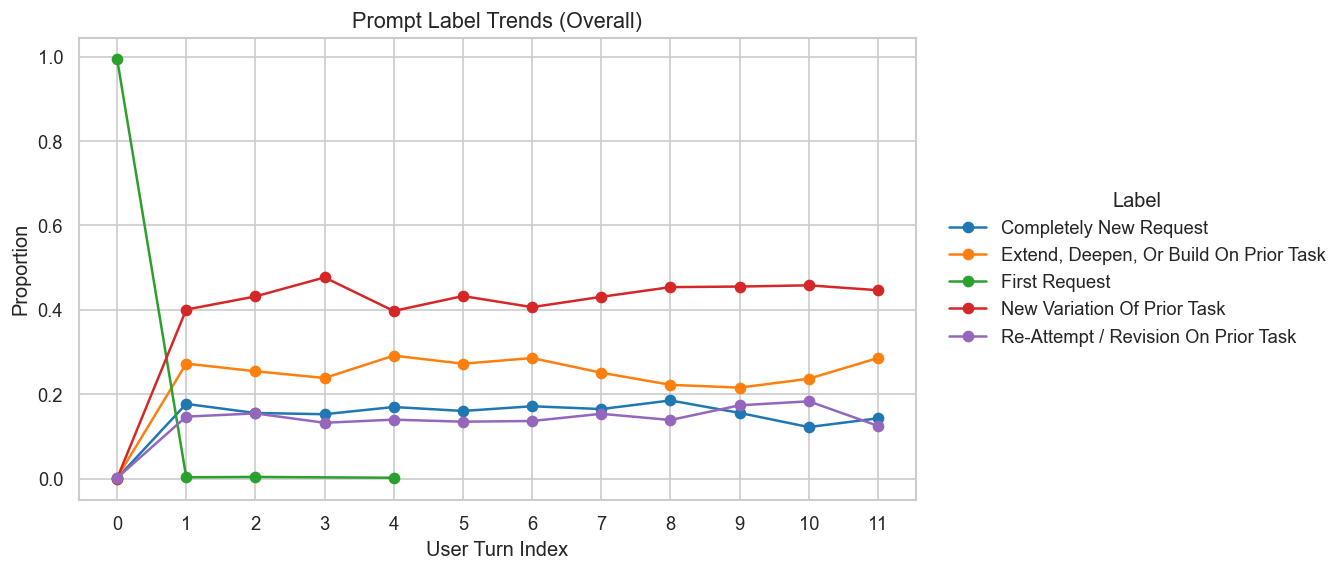

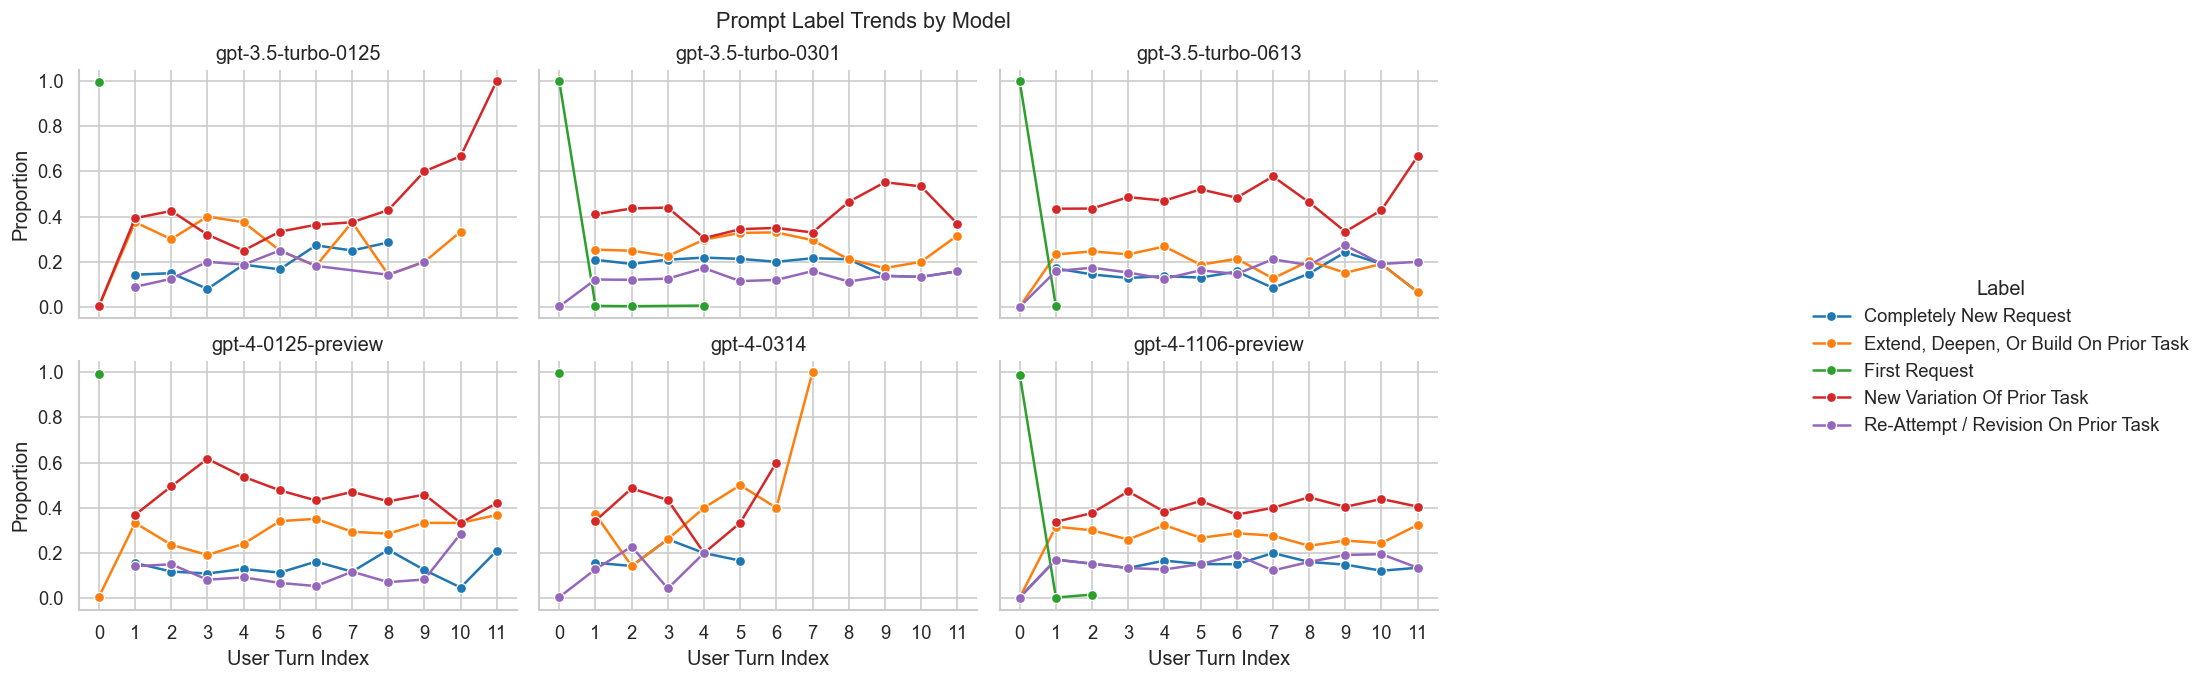

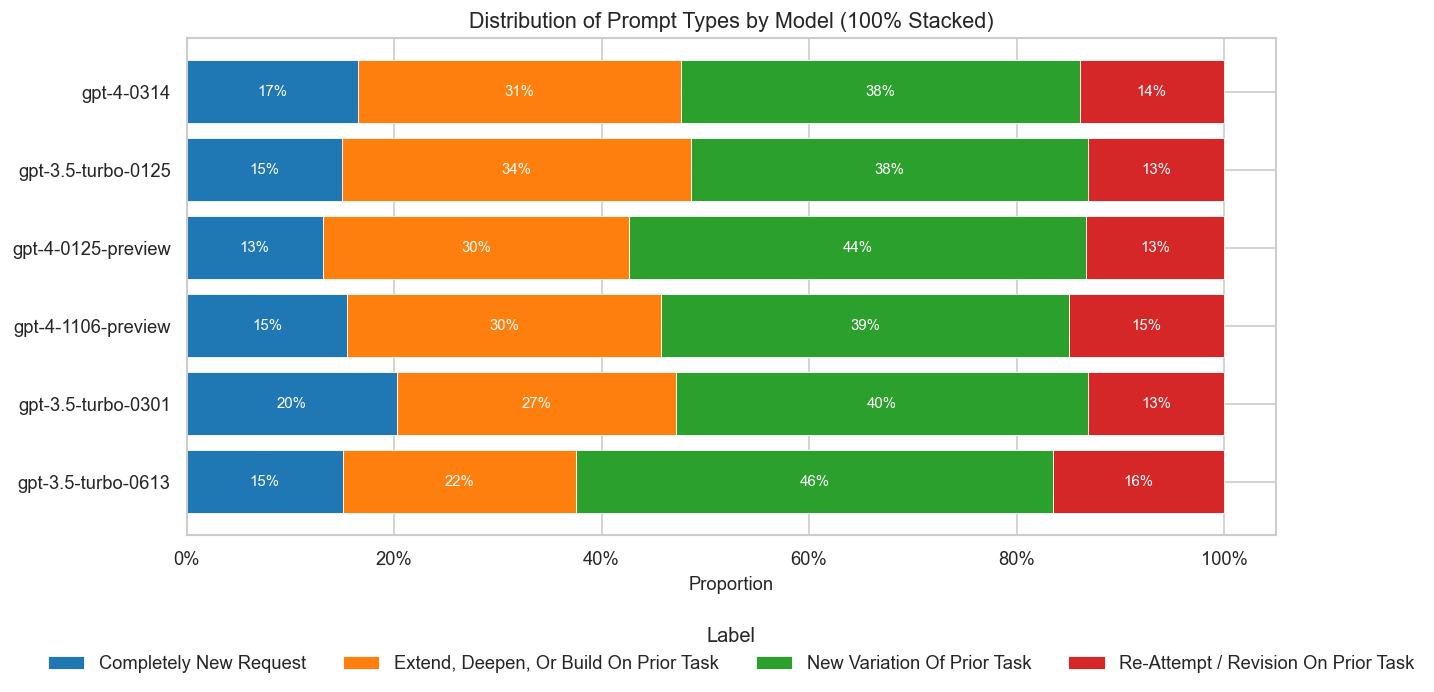

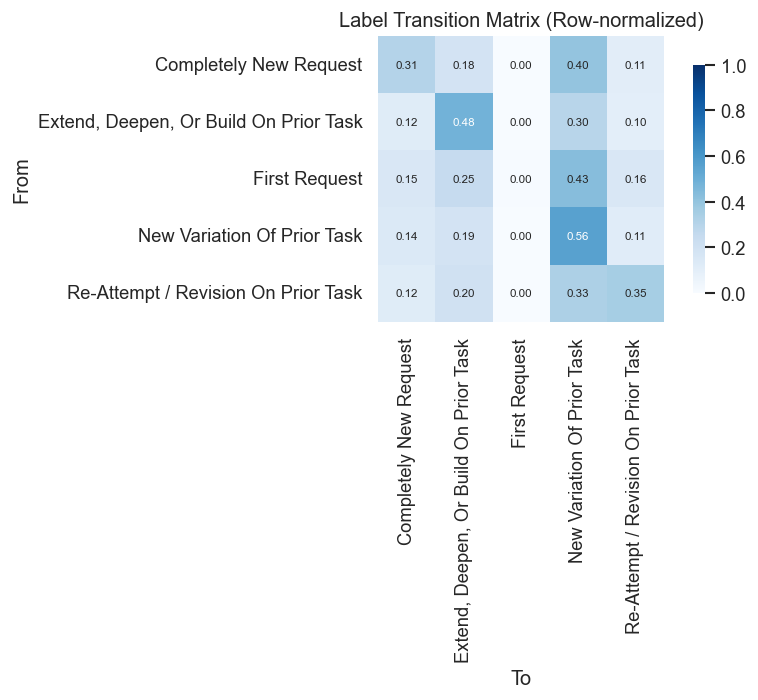

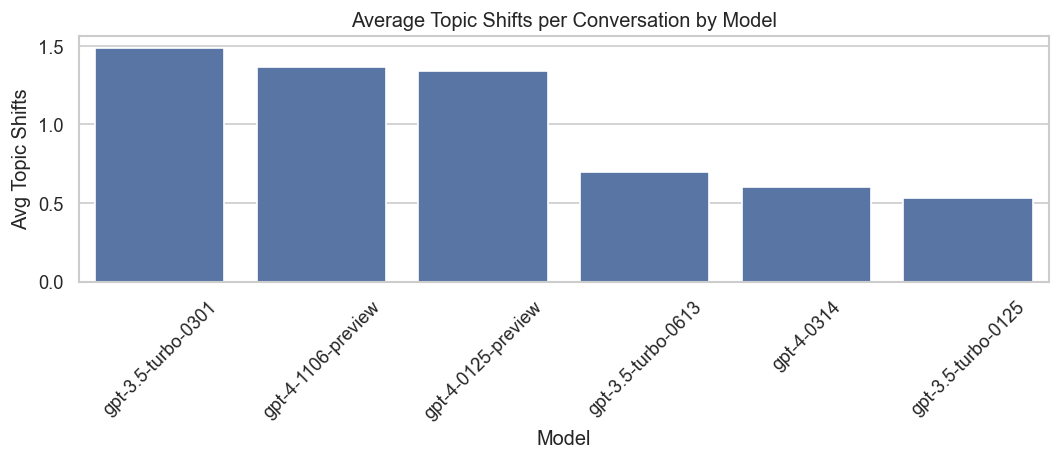

In [8]:
# Make a consistent working copy for all plots
turns_df = turn_df_model.rename(columns={
    "turn_index": "turn",
    "conversation_id": "conv_id"
})

# 1) Overall trends
plot_label_trends_overall(
    df=turns_df, turn_col="turn", label_col="label",
    top_k_labels=6, turn_cutoff=12, xticks_step=1,
    title="Prompt Label Trends (Overall)"
)

# 2) Faceted by model
plot_faceted_label_trends_by_group(
    df=turns_df, group_col="model", turn_col="turn", label_col="label",
    top_k_labels=6, turn_cutoff=12, xticks_step=1,
    title="Prompt Label Trends by Model"
)

# 3) 100% stacked by model
plot_stacked_100h_by_group(
    df=turns_df, group_col="model", label_col="label",
    exclude_labels=["First Request"],
    title="Distribution of Prompt Types by Model (100% Stacked)"
)

# 4) Transition heatmap (overall)
mat = build_transition_matrix_from_tidy(
    df=turns_df, id_col="conv_id", turn_col="turn", label_col="label",
    even_only=True
)
plot_transition_heatmap_matrix(
    matrix=mat, normalize=True,
    title="Label Transition Matrix (Row-normalized)",
    square=True, annot=True, annot_fontsize=7
)


# 6) Topic shifts per conversation and avg by model
shifts_df = compute_topic_shifts_per_conversation(
    df=turns_df, id_col="conv_id", turn_col="turn", label_col="label", even_only=False
)
id_to_model = turns_df[["conv_id", "model"]].drop_duplicates()
model_shift_df = aggregate_topic_shifts_by_group(
    shifts_df, id_to_model, id_col="conv_id", group_col="model", agg="mean"
)
plot_group_metric_bar(
    df=model_shift_df, group_col="model", metric_col="avg_topic_shifts",
    title="Average Topic Shifts per Conversation by Model",
    xlabel="Model", ylabel="Avg Topic Shifts", rotation=45
)

# 7a) Sankey (overall)
flows_overall = build_flows_from_tidy(
    df=turns_df, id_col="conv_id", turn_col="turn", label_col="label"
)
plot_sankey(
    flows=flows_overall, max_user_turns=4,
    title="User Prompt Label Flows (first 4 user turns)"
)

# 7b) Sankey (per model)
for m in sorted(turns_df["model"].dropna().unique()):
    flows_m = build_flows_from_tidy(
        df=turns_df[turns_df["model"] == m],
        id_col="conv_id", turn_col="turn", label_col="label"
    )
    if not flows_m:
        continue
    plot_sankey(
        flows=flows_m, max_user_turns=4,
        title=f"User Prompt Label Flows — {m} (first 4 user turns)"
        # save_html=f"./sankey_outputs/sankey_{m.replace('/', '_')}.html",  # optional save
    )


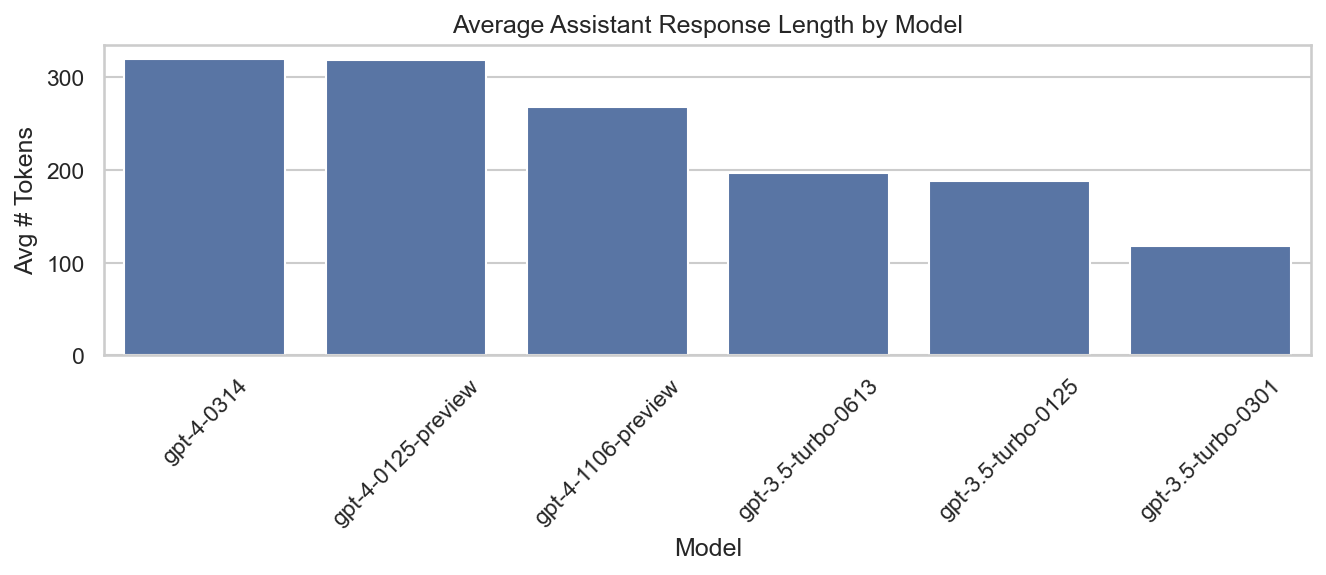

In [9]:
# Build a tidy messages DataFrame
rows = []
for conv in dataset.data:
    for msg in conv.conversation:
        rows.append({"model": conv.model, "role": msg.role, "content": msg.content})
msgs_df = pd.DataFrame(rows)

# Plot
_ = plot_avg_assistant_length_by_group(
    msgs_df=msgs_df,
    group_col="model",
    # length_fn=my_tokenizer_len,  # optional: your tokenizer
    order="desc",
    title="Average Assistant Response Length by Model",
    xlabel="Model",
    ylabel="Avg # Tokens",
    rotation=45,
    show=True
)
